# Reduced Rate-Based Model

This code implements a version of the mean-field rate-based reduced model.

In [59]:
import brian2 as b2  # used for unit checking
from brian2 import np
from brian2 import plt
import networkx as nx
from scipy import special, integrate

from time import sleep
from IPython.display import clear_output
from matplotlib import cm


np.random.seed(123)

# Parameters
defaultdt = 0.2 * b2.ms  # 0.5ms too large, causes assertion errors as firing rates jump too much
# defaultdt = 0.7 * b2.ms
tau_selfconsistent = 0.5 * b2.ms

N = 1000
N_E = int(N * 0.8)
N_I = int(N * 0.2)
f = 0.1
p = 5
N_sub = int(N_E * f)
N_non = int(N_E * (1. - f * p))
w_plus = 2.1
w_minus = 1. - f * (w_plus - 1.) / (1. - f)

V_L = -70. * b2.mV
V_thr = -50. * b2.mV
V_reset = -55. * b2.mV
V_E = 0. * b2.mV
V_I = -70. * b2.mV

g_AMPA_ext_E = 2.08 * b2.nS
g_AMPA_rec_E = 0.104 * b2.nS * 800. / N_E
g_AMPA_ext_I = 1.62 * b2.nS
g_AMPA_rec_I = 0.081 * b2.nS * 800. / N_E
tau_AMPA = 2. * b2.ms

tau_rp_E = 2. * b2.ms
tau_rp_I = 1. * b2.ms

C_m_E = 0.5 * b2.nF
C_m_I = 0.2 * b2.nF
tau_rp_E = 2. * b2.ms
tau_rp_I = 1. * b2.ms
g_m_E = 25. * b2.nS
g_m_I = 20. * b2.nS

rate_ext = 3 * b2.Hz
C_ext = 800

g_NMDA_E = 0.327 * b2.nS * 800. / N_E
g_NMDA_I = 0.258 * b2.nS * 800. / N_E
tau_NMDA_rise = 2. * b2.ms
tau_NMDA_decay = 100. * b2.ms
alpha = 0.5 / b2.ms
tau_NMDA = tau_NMDA_rise * alpha * tau_NMDA_decay

gamma_JahrStevens = 1. / 3.57  # Mg2
beta_JahrStevens = 0.062 / b2.mV

g_GABA_E = 1.25 * b2.nS * 200. / N_I
g_GABA_I = 0.973 * b2.nS * 200. / N_I
tau_GABA = 10. * b2.ms

V_avg_initial = -52.5 * b2.mV  # guess to start

# initial guesses
rate_interneuron = 20 * b2.Hz
rate_pyramidal = 3 * b2.Hz
rate_pyramidal_1 = 90 * b2.Hz  # to use to find fixed points

## Steady-State $\langle s_{NMDA} \rangle$ Values and Truncation

In [60]:
# Functions to compute steady-state NMDA channels
def _get_Tn_summand(n, m, nu):
    assert n >= 1 and m >= 0
    tau_NMDA = alpha * tau_NMDA_rise * tau_NMDA_decay
    binom_coeff = (-1)**m * special.binom(n, m)
    numerator = tau_NMDA_rise * (1 + nu * tau_NMDA)
    denominator = tau_NMDA_rise * (1 + nu * tau_NMDA) + m * tau_NMDA_decay
    return binom_coeff * numerator / denominator

def _get_Tn(n, nu):
    assert n >= 1
    Tn = 0
    for m in np.arange(0, n+1):
        Tn += _get_Tn_summand(n, m, nu)
    return Tn

def psi(nu, n_truncate=5):
    """
    Computes fraction of open NMDA channels given presynaptic firing rate nu 
    up until truncation round-off n_truncate.
    """
    tau_NMDA = alpha * tau_NMDA_rise * tau_NMDA_decay
    coeff = nu * tau_NMDA / (1 + nu * tau_NMDA)
    summation = 0
    for n in np.arange(1, n_truncate+1):
        summand_coeff = ((-alpha * tau_NMDA_rise)**n) / special.factorial(n+1)
        summation += summand_coeff * _get_Tn(n, nu)
    return coeff * (1 + summation / (1 + nu * tau_NMDA))

In [61]:
# we can truncate early
Hz = np.linspace(0, 80, 20) * b2.Hz
truncations = [1, 2, 3, 5, 10, 20]

most_accurate_truncation = 100
most_accurate = []
for hz in Hz:
    most_accurate.append(psi(hz, n_truncate=most_accurate_truncation))
most_accurate = np.array(most_accurate)

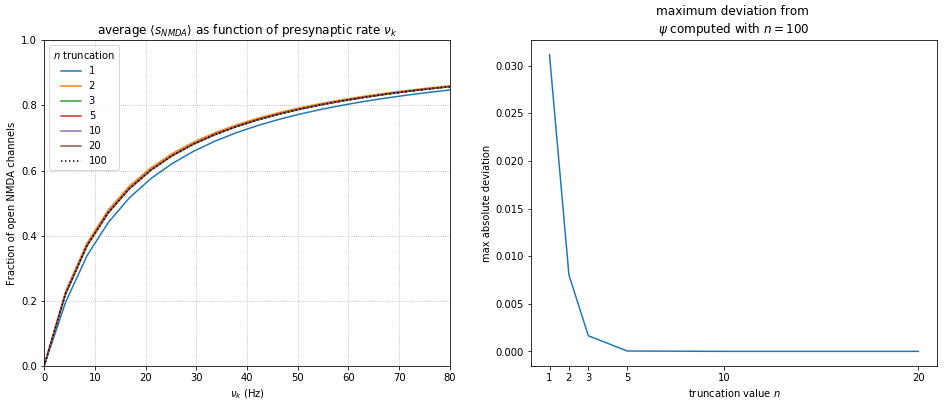

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

max_abs_deviations = []
for n_truncate in truncations:
    s_NMDA_vals = []
    for hz in Hz:
        s_NMDA_vals.append(psi(hz, n_truncate=n_truncate))
    s_NMDA_vals = np.array(s_NMDA_vals)
    max_abs_deviations.append(np.max(
        np.abs(s_NMDA_vals - most_accurate)
    ))
    axes[0].plot(Hz / b2.Hz, s_NMDA_vals, label=n_truncate)
    
axes[0].plot(Hz / b2.Hz, most_accurate, 'k:', label=most_accurate_truncation)
axes[0].grid(ls=':')
axes[0].legend(title='$n$ truncation')
axes[0].set_ylim([0.0, 1.0])
axes[0].set_xlim([0.0, 80.0])
axes[0].set_title(r'average $\langle s_{NMDA} \rangle$ as function of presynaptic rate $\nu_k$')
axes[0].set_xlabel(r'$\nu_k$ (Hz)')
axes[0].set_ylabel('Fraction of open NMDA channels')
axes[1].plot(truncations, max_abs_deviations)
axes[1].set_xticks(truncations)
axes[1].set_xlabel('truncation value $n$')
axes[1].set_ylabel('max absolute deviation')
axes[1].set_title(f'maximum deviation from \n$\psi$ computed with $n={most_accurate_truncation}$')
fig.savefig('psi_truncation.png')
plt.show()

## The Jahr-Stevens Linearisation

Linearising the [Jahr-Stevens formula](https://www.jneurosci.org/content/10/9/3178.short) with the driving force $V(t) - V_E$, given by

$$
\frac{(V(t) - V_E)}{1 + \gamma \exp(-\beta V(t))} =: \frac{(V(t) - V_E)}{J(V)} =: F(V)
$$

around the average membrane potential $\langle V \rangle$ (and writing $V = V(t)$) gives me

$$
\begin{split}
F(V) &\approx F(\langle V \rangle) + \frac{dF(\langle V \rangle)}{dV} (V - \langle V \rangle)\\
&= \frac{\langle V \rangle - V_E}{J(\langle V \rangle)} + (V - \langle V \rangle) \left(\frac{J(\langle V \rangle) + \beta(\langle V \rangle - V_E)(J(\langle V \rangle) - 1)}{J(\langle V \rangle)^2}   \right)\\
&=: \frac{\langle V \rangle - V_E}{J(\langle V \rangle)} + (V - \langle V \rangle) J_2(\langle V \rangle)
\end{split}
$$

This reduces to the formulation in [Brunel and Wang](https://link.springer.com/article/10.1023/A:1011204814320), given by

$$
F(V) \approx \frac{V - V_E}{J(\langle V \rangle)} + (V - \langle V \rangle)\left(\frac{\beta(\langle V \rangle - V_E)(J(\langle V \rangle) - 1)}{J(\langle V \rangle)^2}   \right)
$$

while in the [Feng collection](https://books.google.co.za/books?hl=en&lr=&id=tYwCtQfJfVMC&oi=fnd&pg=PA425&dq=mean-field+theory+of+irregularly+spiking+neurons+brunel+wang+renart&ots=q7bgEVAjnj&sig=bGEEVNgfaJBGbucoGRnJ11Ko3qE&redir_esc=y#v=onepage&q&f=false) the same authors arrive at

$$
F(V) \approx \frac{V - V_E}{J(\langle V \rangle)} + (V - \langle V \rangle) \left(\frac{J(\langle V \rangle) + \beta(\langle V \rangle - V_E)(1 - J(\langle V \rangle))}{J(\langle V \rangle)^2}   \right)
$$

which doesn't seem to fit at all.

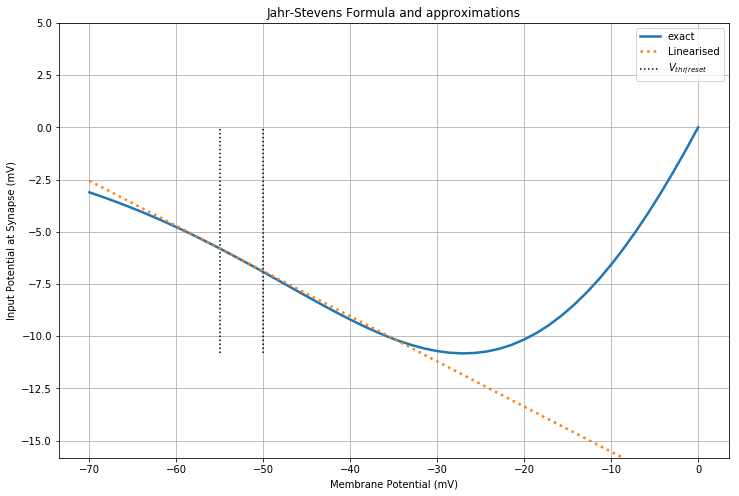

In [63]:
# Jahr-Stevens approximations
def J(V):
    return 1 + gamma_JahrStevens * np.exp(-beta_JahrStevens * V)

def J_2(V):
    J_V = J(V)
    numerator = J_V + beta_JahrStevens * (V - V_E)*(J_V - 1)
    denominator = J_V**2
    return numerator / denominator

def J_2_BrunelWangPaper(V):
    J_V = J(V)
    return beta_JahrStevens * (V - V_E)*(J_V - 1)/(J_V**2)

def J_2_FengChapter(V):
    J_V = J(V)
    numerator = J_V + beta_JahrStevens * (V - V_E)*(1 - J_V)
    denominator = J_V**2
    return numerator / denominator

V = np.linspace(-70*b2.mV, 0*b2.mV, 50)
V_ = -55 * b2.mV
# V_ = -70.39 * b2.mV

g_V = (V - V_E) / J(V)
g_V_linearised = (V_ - V_E) / J(V_) + (V - V_)*J_2(V_)
# g_V_BWpaper = (V - V_E) / J(V_) + (V - V_)*J_2_BrunelWangPaper(V_)
# g_V_FengCh = (V - V_E) / J(V_) + (V - V_)*J_2_FengChapter(V_)  # wrong

# min_g = np.min(np.concatenate([g_V, g_V_linearised, g_V_BWpaper, g_V_FengCh]))
min_g = np.min(g_V)
# max_g = np.max(np.concatenate([g_V, g_V_linearised, g_V_BWpaper, g_V_FengCh]))
max_g = np.max(g_V)

plt.figure(figsize=(12, 8))
plt.plot(V / b2.mV, g_V / b2.mV, label='exact', linewidth=2.5)
# plt.plot(V / b2.mV, g_V_BWpaper / b2.mV, label='Brunel&WangPaper', linewidth=2.5, ls='--')
plt.plot(V / b2.mV, g_V_linearised / b2.mV, label='Linearised', linewidth=2.5, ls=':')
# plt.plot(V / b2.mV, g_V_FengCh / b2.mV, label='FengChapter', linewidth=2.5, ls=':')
plt.vlines(
    [V_thr  / b2.mV,  V_reset / b2.mV],
    min_g / b2.mV, max_g / b2.mV,
    linestyle=':', label=r'$V_{thr/reset}$')
plt.xlabel('Membrane Potential (mV)')
plt.ylabel('Input Potential at Synapse (mV)')
plt.title("Jahr-Stevens Formula and approximations")
# plt.yticks([])
plt.ylim([min_g/b2.mV - 5, max_g/b2.mV + 5])
plt.legend()
plt.grid()

plt.savefig('jahrstevens.png')
plt.show()

In [64]:
# double-checking the parameters
g_NMDA = g_NMDA_E
g_NMDA_eff = g_NMDA * J_2(V_)
V_E_eff = V_ - (g_NMDA / g_NMDA_eff)*((V_ - V_E)/J(V_))
# These should be close to -82 mV and -0.22
V_E_eff, g_NMDA_eff / g_NMDA

(-81.82656564 * mvolt, -0.21631991924446492)

## Siegert / Inverse First Passage Time Formula

In [65]:
# First passage time formula
def siegert_integrand(x):
    return np.exp(x**2)*(1+special.erf(x))

def phi_siegert(
    tau_refrac, tau_m_eff, lower_bound, upper_bound,
    tolerance=1.49e-08, limit=1000
):
    integral, error = integrate.quad(
        siegert_integrand,
        lower_bound,
        upper_bound,
        limit=limit,
        epsabs=tolerance
    )
        
    return (tau_refrac + tau_m_eff * np.sqrt(np.pi) * integral)**-1

WARNING    /home/dean/anaconda3/envs/masters/lib/python3.7/site-packages/ipykernel_launcher.py:14: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  
 [py.warnings]
WARNING    /home/dean/anaconda3/envs/masters/lib/python3.7/site-packages/ipykernel_launcher.py:14: IntegrationWarning: The maximum number of subdivisions (1000) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  
 [py.warnings]


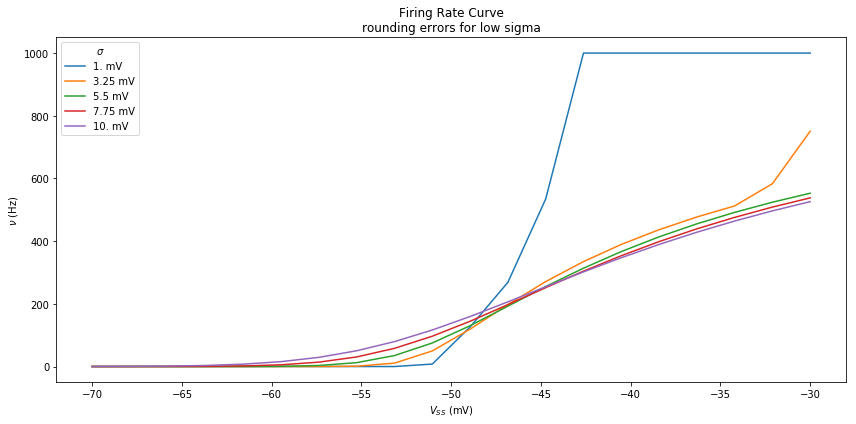

In [66]:
plt.figure(figsize=(12, 6))

tau_m_eff = 3 * b2.ms
b = np.sqrt(tau_AMPA / tau_m_eff)
tau_refrac = 1 * b2.ms
sigma_vals = np.linspace(1, 10, 5) * b2.mV
for sigma in sigma_vals:
    V_SS = np.linspace(-70, -30, 20) * b2.mV
    UB = (V_thr - V_SS)/sigma + 1.03*b
    LB = (V_reset - V_SS)/sigma + 1.03*b
    phi_vals = []
    for lb, ub in zip(LB, UB):
        phi = phi_siegert(
            tau_refrac, tau_m_eff, lb, ub
        )
        phi_vals.append(phi)
    plt.plot(V_SS / b2.mV, phi_vals, label=sigma)
plt.xlabel(r'$V_{SS}$ (mV)')
plt.ylabel(r'$\nu$ (Hz)')
plt.legend(title=r'$\sigma$')
plt.title('Firing Rate Curve\nrounding errors for low sigma')
plt.tight_layout()
plt.show()

In [67]:
# check Euler method

In [68]:
# Not used anymore

# Effective parameters
# def get_g_NMDA_eff(V, g_NMDA_kl):
#     return g_NMDA_kl * J_2(V)

# def get_V_E_eff(V):
#     return V - (1/J_2(V))*(V - V_E)/J(V)

# def tau_NMDA_eff(nu):
#     return tau_NMDA * (1 - psi(nu))

# tau_NMDA_eff(1*b2.Hz)

In [69]:
# Break on NaNs and numerical error
from collections.abc import Iterable


def check_for_nan_helper(r, func_name):
    if isinstance(r, float) or isinstance(r, int):
        if np.isnan(r):
            raise Exception(f"NaN occurred in {func_name}")
    return None

def check_for_nan(func):
    """
    Raises Exception if decorated function returns a NaN.  
    Useful for early stopping when numerical errors arise.
    """
    def new_func(*args, **kwargs):
        result = func(*args, **kwargs)
        if isinstance(result, tuple):
            for r in result:
                check_for_nan_helper(
                    float(r),
                    func_name=func.__name__
                )
        else:
            check_for_nan_helper(
                float(result),
                func_name=func.__name__
            )
        return result
    return new_func

In [70]:
class NeuronGroupBase:
    """
    Base class to define methods and parameters available 
    to all neuron populations.
    """
    def __init__(
        self, name, C_k,
        network = None
    ):
        self.name = name
        self.network = network  # used to manage synapses etc
        self.C_k = C_k
        # automatically add to network
        if self.network is not None:
            assert isinstance(self.network, nx.DiGraph), type(self.network)
            self.network.add_node(self)
    
    def __hash__(self):
        return hash(self.name)
    
    def __eq__(self, other):
        if not isinstance(other, type(self)):
            return False
        return other.name == self.name
    
    def __str__(self):
        return self.name
    
    def __repr__(self):
        return self.name
    
    # cell-type dependent parameters to be overwritten
    def s_AMPA_ext(self):
        return None
    
    def s_AMPA(self):
        return None
    
    def s_NMDA(self):
        return None
    
    def s_GABA(self):
        return None

In [71]:
class NeuronGroup(NeuronGroupBase):
    """
    Dynamic neuron populations, with varying firing rates and 
    average membrane potentials (and effective parameters).
    """
    def __init__(
        self, name,  # unique identifier name
        C_k, C_m, g_m, 
        g_AMPA_ext, g_AMPA, g_NMDA, g_GABA,
        tau_refrac,
        network = None,
        nu_initial = 3 * b2.Hz,
        V_avg_initial = -52.5 * b2.mV,
        h_initial = -20 * b2.mV
    ):
        super().__init__(
            name=name,
            C_k=C_k,
            network=network
        )
        # constants
        self.C_m = C_m
        self.g_m = g_m
        self.C_k = C_k
        self.g_AMPA_ext = g_AMPA_ext
        self.g_AMPA = g_AMPA
        self.g_NMDA = g_NMDA
        self.g_GABA = g_GABA
        self.tau_refrac = tau_refrac
        
        # dynamic variables
        self.nu_trace = [nu_initial]
        self.DeltaI_trace = [0 * b2.amp]
        self.V_avg_trace = [V_avg_initial]
        self.h_trace = [h_initial]
    
    # accessing recorded parameters
    def nu(self):
        return self.nu_trace[-1]
    
    def DeltaI(self):
        return self.DeltaI_trace[-1]
    
    def V_avg(self):
        return self.V_avg_trace[-1]
    
    def h(self):
        return self.h_trace[-1]
    
    # accessing "effective" parameters
    @check_for_nan
    def g_NMDA_eff(self):
        return self.g_NMDA * J_2(self.V_avg())
    
    @check_for_nan
    def g_m_eff(self):
        value = self.g_m
        for other_group, _, info in self.network.in_edges(self, data=True):
            w_A = info.get('w_A', 1.0)
            w_N = info.get('w_N', 1.0)
            w_I = info.get('w_I', 1.0)
            C_k = other_group.C_k
            
            s_AMPA_ext = other_group.s_AMPA_ext()
            if s_AMPA_ext:
                value += s_AMPA_ext * self.g_AMPA_ext * C_k
                continue
            s_AMPA = other_group.s_AMPA()
            s_NMDA = other_group.s_NMDA()
            if s_AMPA:
                value += s_AMPA * w_A * self.g_AMPA * C_k
                value += s_NMDA * w_N * self.g_NMDA_eff() *  C_k
                continue            
            s_GABA = other_group.s_GABA()
            if s_GABA:
                value += s_GABA * w_I * self.g_GABA * C_k
        return value
    
    @check_for_nan
    def tau_m(self):
        return self.C_m / self.g_m
    
    @check_for_nan
    def tau_m_eff(self):
        return self.C_m / self.g_m_eff()
    
    @check_for_nan
    def V_E_eff(self):
        V_avg = self.V_avg()
        # Note: g_NMDA / g_NMDA_eff = 1/J_2(V_avg)
        return V_avg - (1/J_2(V_avg))*(V_avg - V_E)/J(V_avg)
    
    @check_for_nan
    def V_SS(self):
        value = self.g_m * V_L
        for other_group, _, info in self.network.in_edges(self, data=True):
            w_A = info.get('w_A', 1.0)
            w_N = info.get('w_N', 1.0)
            w_I = info.get('w_I', 1.0)
            C_k = other_group.C_k
            
            s_AMPA_ext = other_group.s_AMPA_ext()
            if s_AMPA_ext:
                value += s_AMPA_ext * self.g_AMPA_ext * C_k * V_E
                continue
            s_AMPA = other_group.s_AMPA()
            s_NMDA = other_group.s_NMDA()
            if s_AMPA:
                value += s_AMPA * w_A * self.g_AMPA * C_k * V_E
                value += s_NMDA * w_N * self.g_NMDA_eff() *  C_k * self.V_E_eff()
                continue            
            s_GABA = other_group.s_GABA()
            if s_GABA:
                value += s_GABA * w_I * self.g_GABA * C_k * V_I
        g_m_eff = self.g_m_eff()
        return value / g_m_eff
    
    @check_for_nan
    def sigma_C_eff(self):
        value = None
        for other_group, _, info in self.network.in_edges(self, data=True):
            if isinstance(other_group, ExternalGroup):
                C_ext = other_group.C_k
                s_AMPA_ext = other_group.s_AMPA_ext()
                value = np.abs(self.g_AMPA_ext * (self.V_avg() - V_E) * np.sqrt(C_ext * s_AMPA_ext * tau_AMPA))
                break
        return value
    
    # TODO: Should this be doubled or something?
    # It would effectively double the number of external inputs
    @check_for_nan
    def sigma_V_eff(self):
        tau_m_eff = self.tau_m_eff()
        return self.sigma_C_eff() * np.sqrt(tau_m_eff) / self.C_m
    
    @check_for_nan
    def mu_C_eff(self):
        g_m_eff = self.g_m_eff()
        V_SS = self.V_SS()
        g_m = self.g_m
        return V_SS * g_m_eff - V_L * g_m
    
    # determining derivatives for dynamic variables and "self-consistently" computed variables
    # these can be used to plot trajectories of the variables conditioned on other variables
    # being static, which should help with debugging
    @check_for_nan
    def dnuDt(self, return_asymptote=False, **kwargs):
        nu = kwargs.get('nu', self.nu())
        tau = kwargs.get('tau_m_eff', self.tau_m_eff())
        
        asymptote = self.compute_new_firing_rate()
        dnuDt = (-nu + asymptote)/tau
        if return_asymptote:
            return dnuDt, asymptote
        return dnuDt
    
    @check_for_nan
    def dV_avgDt(self, return_asymptote=False, **kwargs):
        V_avg = kwargs.get('V_avg', self.V_avg())
        tau = kwargs.get('tau', tau_selfconsistent)
        V_SS = kwargs.get('V_SS', self.V_SS())
        nu = kwargs.get('nu', self.nu())
        tau_m_eff = kwargs.get('tau_m_eff', self.tau_m_eff())
        asymptote = V_SS - (V_thr - V_reset)*nu*tau_m_eff - (V_SS - V_reset)*nu*self.tau_refrac
        dV_avgDt = (-V_avg + asymptote)/tau
        if return_asymptote:
            return dV_avgDt, asymptote
        return dV_avgDt
    
    @check_for_nan
    def dDeltaIDt(self, return_asymptote=False, **kwargs):
        """Set xi = 0/np.sqrt(b2.ms) to get asymptote without noise"""
        DeltaI = kwargs.get('DeltaI', self.DeltaI())
        xi = kwargs.get('xi', np.random.randn() / np.sqrt(defaultdt))
        sigma_C_eff = kwargs.get('sigma_C_eff', self.sigma_C_eff())
        tau_m_eff = kwargs.get('tau_m_eff', self.tau_m_eff())
        dDeltaIDt = (-DeltaI + sigma_C_eff*xi) / tau_m_eff
        if return_asymptote:
            return dDeltaIDt, asymptote
        return dDeltaIDt
    
    @check_for_nan
    def dhDt(self, return_asymptote=False, **kwargs):
        h = kwargs.get('h', self.h())
        tau_m_eff = kwargs.get('tau_m_eff', self.tau_m_eff())
        mu_C_eff = kwargs.get('mu_C_eff', self.mu_C_eff())
        DeltaI = kwargs.get('DeltaI', self.DeltaI())
        g_m_eff = kwargs.get('g_m_eff', self.g_m_eff())
        asymptote = (1/g_m_eff) * (mu_C_eff + DeltaI)
        dhDt = (-h + asymptote) / tau_m_eff
        if return_asymptote:
            return dhDt, asymptote
        return dhDt
    
    @check_for_nan
    def compute_new_V_avg_selfconsistently(
        self,
        timeconst=tau_selfconsistent, # used to scale defaultdt
        max_iterations=1000,
        tolerance = 0.001 * b2.mV
    ):
        """Drives V_avg to converge self-consistently to its own definition."""
        nu = self.nu()
        # temporarily mutates last value in trace for other methods to access it
        V_avg_original = self.V_avg()
        V_avg_old = V_avg_original.copy()
        for i in range(max_iterations):
            dV_avgDt, asymptote = self.dV_avgDt(
                return_asymptote=True,
                tau=timeconst
            )
            V_avg_new = V_avg_old + defaultdt*dV_avgDt
            self.V_avg_trace[-1] = V_avg_new
            if np.abs(V_avg_new - asymptote) < tolerance:
                break
#             if np.abs(V_avg_new - V_avg_old) < tolerance:
#                 break
            V_avg_old = V_avg_new
        else:
            print('V_avg did not converge in alotted timesteps')
        self.V_avg_trace[-1] = V_avg_original
        return V_avg_new
    
    @check_for_nan
    def compute_new_DeltaI(self):
        DeltaI = self.DeltaI()
        dDeltaIDt = self.dDeltaIDt(DeltaI=DeltaI)
        return DeltaI + defaultdt * dDeltaIDt
    
    @check_for_nan
    def compute_new_h(self):
        h = self.h()
        dhDt = self.dhDt(h=h)
        return h + defaultdt * dhDt
    
    @check_for_nan
    def V_thr_eff(
        self,
        b=None,
        sigma_V_eff=None
    ):
        a = 1.03
        if b is None:
            tau_m_eff = self.tau_m_eff()
            b = np.sqrt(tau_AMPA / tau_m_eff)
        if sigma_V_eff is None:
            sigma_V_eff = self.sigma_V_eff()
        return V_thr + sigma_V_eff * a * b
    
    @check_for_nan
    def V_reset_eff(
        self,
        b=None,
        sigma_V_eff=None
    ):
        a = 1.03
        if b is None:
            tau_m_eff = self.tau_m_eff()
            b = np.sqrt(tau_AMPA / tau_m_eff)
        if sigma_V_eff is None:
            sigma_V_eff = self.sigma_V_eff()
        return V_reset + sigma_V_eff * a * b
        
    @check_for_nan
    def first_passage_bounds(
        self, tau_m_eff=None
    ):
        if tau_m_eff is None:
            tau_m_eff = self.tau_m_eff()
        g_m_eff = self.g_m_eff()
        g_m = self.g_m
        h = self.h()
        leak_term = V_L * g_m / g_m_eff
        b = np.sqrt(tau_AMPA / tau_m_eff)
        sigma_V_eff = self.sigma_V_eff()
        V_thr_eff = self.V_thr_eff(b=b, sigma_V_eff=sigma_V_eff)
        V_reset_eff = self.V_reset_eff(b=b, sigma_V_eff=sigma_V_eff)
        
        lower_bound = (V_reset_eff - h - leak_term) / sigma_V_eff
        upper_bound = (V_thr_eff - h - leak_term) / sigma_V_eff
        return lower_bound, upper_bound
    
    @check_for_nan
    def first_passage_bounds_Vsteadystate(
        self, tau_m_eff=None
    ):
        if tau_m_eff is None:
            tau_m_eff = self.tau_m_eff()
        g_m_eff = self.g_m_eff()
        g_m = self.g_m
        b = np.sqrt(tau_AMPA / tau_m_eff)
        sigma_V_eff = self.sigma_V_eff()
        V_thr_eff = self.V_thr_eff(b=b, sigma_V_eff=sigma_V_eff)
        V_reset_eff = self.V_reset_eff(b=b, sigma_V_eff=sigma_V_eff)
        V_SS = self.V_SS()
        
        lower_bound = (V_reset_eff - V_SS) / sigma_V_eff
        upper_bound = (V_thr_eff - V_SS) / sigma_V_eff
        return lower_bound, upper_bound
    
    # TODO: differentiate the "compute_new" functions between those which
    # update instantly and those which use Euler updates
    @check_for_nan
    def compute_new_firing_rate(
        self, tolerance=1.49e-08, limit=1000
    ):
        tau_m_eff = self.tau_m_eff()
        lower_bound, upper_bound = self.first_passage_bounds(
            tau_m_eff=tau_m_eff
        )
        rate = phi_siegert(
            self.tau_refrac, tau_m_eff,
            lower_bound, upper_bound,
            tolerance=tolerance, limit=limit
        )
        return rate
    
    @check_for_nan
    def compute_new_firing_rate_Vsteadystate(
        self, tolerance=1.49e-08, limit=1000
    ):
        tau_m_eff = self.tau_m_eff()
        lower_bound, upper_bound = self.first_passage_bounds_Vsteadystate(
            tau_m_eff=tau_m_eff
        )
        rate = phi_siegert(
            self.tau_refrac, tau_m_eff,
            lower_bound, upper_bound,
            tolerance=tolerance, limit=limit
        )
        return rate
    
    @check_for_nan
    def compute_new_firing_rate_euler(
        self, tolerance=1.49e-08, limit=1000
    ):
        nu = self.nu()
        dnuDt = self.dnuDt(nu=nu)
        return nu + defaultdt * dnuDt
    
    @check_for_nan
    def compute_new_firing_rate_selfconsistently_steadystate(
        self,
        timeconst=tau_selfconsistent, # used to scale defaultdt
        max_iterations=1000,
        tolerance = 0.1 * b2.Hz
    ):
        """Drives nu to converge self-consistently to its own definition."""
        # temporarily mutates last value in traces for other methods to access them
        nu_original = self.nu()
        V_avg_original = self.V_avg()
        nu_old = nu_original.copy()
        
        for i in range(max_iterations):
            # set V_avg to asymptote, increment nu
            dV_avgDt, V_avg_new = self.dV_avgDt(return_asymptote=True)
            self.V_avg_trace[-1] = V_avg_new
            
            # use explicit derivative formulation
            asymptote = self.compute_new_firing_rate_Vsteadystate()
            dnuDt = (-nu_old + asymptote)/timeconst
            nu_new = nu_old + defaultdt * dnuDt
            self.nu_trace[-1] = nu_new
            
            if np.abs(nu_new - asymptote) < tolerance:
                break
            nu_old = nu_new
        else:
            print('V_avg did not converge in alotted timesteps')
        self.V_avg_trace[-1] = V_avg_original
        self.nu_trace[-1] = nu_original
        return nu_new

In [72]:
class ExternalGroup(NeuronGroupBase):
    def __init__(
        self, name,
        C_k=C_ext, 
        network=None,
        nu=3 * b2.Hz
    ):
        super().__init__(
            name=name,
            C_k=C_k,
            network=network
        )
        self.nu = nu
    
    def s_AMPA_ext(self):
        return self.nu * tau_AMPA

    
class PyramidalGroup(NeuronGroup):
    def __init__(
        self, name,
        C_k,
        C_m=C_m_E,
        g_m=g_m_E,
        g_AMPA_ext=g_AMPA_ext_E,
        g_AMPA=g_AMPA_rec_E,
        g_NMDA=g_NMDA_E,
        g_GABA=g_GABA_E,
        tau_refrac=tau_rp_E,
        network = None,
        nu_initial = rate_pyramidal,
        V_avg_initial = -52.5 * b2.mV,
        h_initial = 0 * b2.mV,
        s_NMDA_initial = 0,  # fraction of open channels is determined in the "presynaptic" group
    ):
        super().__init__(
            C_m=C_m, g_m=g_m, C_k=C_k, g_AMPA_ext=g_AMPA_ext,
            g_AMPA=g_AMPA, g_NMDA=g_NMDA, g_GABA=g_GABA,
            tau_refrac=tau_refrac,
            name=name, network=network, nu_initial=nu_initial,
            V_avg_initial=V_avg_initial, h_initial=h_initial
        )
        self.s_NMDA_trace = [s_NMDA_initial]
    
    @check_for_nan
    def s_AMPA(self):
        s_AMPA = self.nu() * tau_AMPA
        assert s_AMPA <= 1.0 and s_AMPA >= 0, f"{s_AMPA} not within bounds [0, 1]"
        return s_AMPA
    
    def s_NMDA(self):
        s_NMDA = self.s_NMDA_trace[-1]
        assert s_NMDA <= 1.0 and s_NMDA >= 0, f"{s_NMDA} not within bounds [0, 1]"
        return s_NMDA
    
    @check_for_nan
    def tau_NMDA_eff(self, psi_nu=None):
        if psi_nu is None:
            psi_nu = psi(self.nu())
        return tau_NMDA * (1 - psi_nu)
    
    @check_for_nan
    def ds_NMDA_Dt(self, return_asymptote=False, **kwargs):
        s_NMDA = kwargs.get('s_NMDA', self.s_NMDA())
        psi_nu = kwargs.get('psi', psi(self.nu()))
        tau_NMDA_eff = kwargs.get('tau_NMDA_eff', self.tau_NMDA_eff(
            psi_nu=psi_nu
        ))
        ds_NMDA_Dt = -(s_NMDA - psi_nu)/tau_NMDA_eff
        if return_asymptote:
            return ds_NMDA_Dt, psi_nu
        return ds_NMDA_Dt
    
    # TODO: rewrite using ds_NMDA_Dt
    @check_for_nan
    def compute_new_s_NMDA(self):
        s_NMDA_old = self.s_NMDA()
        psi_nu = psi(self.nu())
        tau_NMDA_eff = self.tau_NMDA_eff(
            psi_nu=psi_nu
        )
        ds_NMDA_Dt = -(s_NMDA_old - psi_nu)/tau_NMDA_eff
        return s_NMDA_old + defaultdt*ds_NMDA_Dt
        

class InterneuronGroup(NeuronGroup):
    def __init__(
        self, name,
        C_k=N_I,
        C_m=C_m_I,
        g_m=g_m_I,
        g_AMPA_ext=g_AMPA_ext_I,
        g_AMPA=g_AMPA_rec_I,
        g_NMDA=g_NMDA_I,
        g_GABA=g_GABA_I,
        tau_refrac=tau_rp_I,
        network = None,
        nu_initial = rate_interneuron,
        V_avg_initial = -52.5 * b2.mV,
        h_initial = 0 * b2.mV
    ):
        super().__init__(
            C_m=C_m, g_m=g_m, C_k=C_k, g_AMPA_ext=g_AMPA_ext,
            g_AMPA=g_AMPA, g_NMDA=g_NMDA, g_GABA=g_GABA,
            tau_refrac=tau_refrac,
            name=name, network=network, nu_initial=nu_initial,
            V_avg_initial=V_avg_initial, h_initial=h_initial
        )
    
    @check_for_nan
    def s_GABA(self):
        s_GABA = self.nu() * tau_GABA
        assert s_GABA <= 1.0 and s_GABA >= 0, f"{s_GABA} not within bounds [0, 1]"
        return s_GABA

In [73]:
class EffectiveParameterTracker:
    """Tracks effective parameters for dynamic neuron groups in network."""
    def __init__(self, network):
        self.network = network
        self.tau_NMDA_eff = {n:[] for n in network.nodes
            if isinstance(n, PyramidalGroup)}
        self.V_reset_eff = {n:[] for n in network.nodes
            if isinstance(n, NeuronGroup)}
        self.V_thr_eff = {n:[] for n in network.nodes
            if isinstance(n, NeuronGroup)}
        self.mu_C_eff = {n:[] for n in network.nodes
            if isinstance(n, NeuronGroup)}
        self.sigma_V_eff = {n:[] for n in network.nodes
            if isinstance(n, NeuronGroup)}
        self.sigma_C_eff = {n:[] for n in network.nodes
            if isinstance(n, NeuronGroup)}
        self.V_SS = {n:[] for n in network.nodes
            if isinstance(n, NeuronGroup)}
        self.V_E_eff = {n:[] for n in network.nodes
            if isinstance(n, NeuronGroup)}
        self.tau_m_eff = {n:[] for n in network.nodes
            if isinstance(n, NeuronGroup)}
        self.g_m_eff = {n:[] for n in network.nodes
            if isinstance(n, NeuronGroup)}
        self.g_NMDA_eff = {n:[] for n in network.nodes
            if isinstance(n, NeuronGroup)}
        self.integral_bounds = {n:[] for n in network.nodes
            if isinstance(n, NeuronGroup)}
    
    def update(self):
        for n in self.tau_NMDA_eff.keys():
            self.tau_NMDA_eff[n].append(n.tau_NMDA_eff())
        for n in self.V_reset_eff.keys():
            self.V_reset_eff[n].append(n.V_reset_eff())
        for n in self.V_thr_eff.keys():
            self.V_thr_eff[n].append(n.V_thr_eff())
        for n in self.mu_C_eff.keys():
            self.mu_C_eff[n].append(n.mu_C_eff())
        for n in self.sigma_V_eff.keys():
            self.sigma_V_eff[n].append(n.sigma_V_eff())
        for n in self.sigma_C_eff.keys():
            self.sigma_C_eff[n].append(n.sigma_C_eff())
        for n in self.V_SS.keys():
            self.V_SS[n].append(n.V_SS())
        for n in self.V_E_eff.keys():
            self.V_E_eff[n].append(n.V_E_eff())
        for n in self.tau_m_eff.keys():
            self.tau_m_eff[n].append(n.tau_m_eff())
        for n in self.g_m_eff.keys():
            self.g_m_eff[n].append(n.g_m_eff())
        for n in self.g_NMDA_eff.keys():
            self.g_NMDA_eff[n].append(n.g_NMDA_eff())
        for n in self.integral_bounds.keys():
            self.integral_bounds[n].append(n.first_passage_bounds())

In [74]:
# rate_pyramidal_1 argument used for debugging
def initialise_network(
    rate_pyramidal=rate_pyramidal,
    rate_interneuron=rate_interneuron,
    rate_pyramidal_1=None
):
    net = nx.DiGraph()
    if rate_pyramidal_1 is None:
        rate_pyramidal_1 = rate_pyramidal
    # add neural group nodes
    dynamic_neuron_groups = [
        PyramidalGroup(
            name='nonsel', C_k=N_non, network=net, nu_initial=rate_pyramidal),
        InterneuronGroup(
            name='inh', C_k=N_I, network=net, nu_initial=rate_interneuron)
    ]
    for i in range(1,p+1):
        if i == 1:
            n = PyramidalGroup(
                name=str(i), C_k=N_sub, network=net, nu_initial=rate_pyramidal_1)
        else:
            n = PyramidalGroup(
                name=str(i), C_k=N_sub, network=net, nu_initial=rate_pyramidal)
        dynamic_neuron_groups.append(n)

    # add edges n1->n2
    for n1 in dynamic_neuron_groups:
        for n2 in dynamic_neuron_groups:
            if isinstance(n1, PyramidalGroup):
                if n1.name == 'nonsel':
                    net.add_edge(n1, n2, w_A=1.0, w_N=1.0)
                elif n1 == n2:
                    net.add_edge(n1, n2, w_A=w_plus, w_N=w_plus)
                elif n2.name == 'inh':
                    net.add_edge(n1, n2, w_A=1.0, w_N=1.0)
                else:
                    net.add_edge(n1, n2, w_A=w_minus, w_N=w_minus)
            else:  # is inhibitory group
                net.add_edge(n1, n2, w_I=1.0)

    # add external populations and edges
    for n in dynamic_neuron_groups:
        ext = ExternalGroup(name=f'ext-{str(n)}', network=net)
        net.add_edge(ext, n)

    # initialisation: set other parameters to steady states
    for n in dynamic_neuron_groups:
        if isinstance(n, PyramidalGroup):
            n.s_NMDA_trace[0] = psi(n.nu())
#             ds_NMDA_Dt, n.s_NMDA_trace[0] = n.ds_NMDA_Dt(return_asymptote=True)
    for n in dynamic_neuron_groups:
            n.V_avg_trace[0] = n.compute_new_V_avg_selfconsistently()
    for n in dynamic_neuron_groups:
        n.h_trace[0] = n.mu_C_eff()/n.g_m_eff()
#         dhDt, n.h_trace[0] = n.dhDt(return_asymptote=True)
    return net

net = initialise_network()
dynamic_neuron_groups = [n for n in net.nodes() if isinstance(n, NeuronGroup)]

In [ ]:
# Take a look at the network
plt.figure(figsize=(8,6))
outer = [n for n in net.nodes() if not n in dynamic_neuron_groups]
inner = dynamic_neuron_groups
pos = nx.shell_layout(net, nlist=[inner, outer])
colours = []
for n in net.nodes:
    if n.name.startswith('ext'):
        colours.append('r')
    elif n.name == 'inh':
        colours.append('y')
    else:
        colours.append('c')
nx.draw_networkx(net, pos=pos, node_size=900, node_color=colours)
plt.axis('off')
plt.show()

First check the initial conditions are right

In [ ]:
n = dynamic_neuron_groups[0]

In [ ]:
# _, asym = n.dhDt(return_asymptote=True)
# asym, n.V_SS() - (n.g_m / n.g_m_eff())*V_L
# n.V_SS() * n.g_m_eff() - V_L * n.g_m

Initially, $\Delta I = 0$A, and $h = \frac{1}{g_m^{eff}} \left( \mu_C^{eff} + \Delta I \right) = \frac{\mu_C^{eff}}{g_m^{eff}}$.  

Since $\mu_C^{eff} = g_m^{eff} V_{SS} - g_m V_L$, we get that initially $h = V_{SS} - \frac{g_m}{g_m^{eff}} V_L$

In [ ]:
# these should be equal
n.h() + V_L * n.g_m / n.g_m_eff(),\
n.V_SS()

In [ ]:
# i.e. this should be zero
n.V_SS() - (n.h() + (n.g_m / n.g_m_eff())*V_L)

In [ ]:
# and hence these should be equal
(V_thr - (n.h() + (n.g_m / n.g_m_eff())*V_L)) / (n.sigma_V_eff() * 2),\
(V_thr - n.V_SS()) / (n.sigma_V_eff() * 2)

In [ ]:
# and so finally these should be equal
n.compute_new_firing_rate(), n.first_passage_bounds(),\
n.compute_new_firing_rate_Vsteadystate(), n.first_passage_bounds_Vsteadystate()

## Plan A

Our Plan A model will work like this:

We will have a $4(p+2)-1$-dimensional dynamical system, where $p$ is the number of selective populations.  
The variables will be (for $k \in \{0, \dots, p, I \}$):
* $\langle s_{NMDA}^k \rangle$ if $k \neq I$, the fraction of open NMDA channels  
* $h^k(t)$, the input potential  
* $\Delta I^k(t)$, the input noise at the external pyramidal synapses
* $\langle V \rangle_k$, the average membrane potential in the population

The firing rates $\nu_k$ are then computed as functions of these parameters at each timestep.  
Implicitly, we assume that $\langle V \rangle_k$ converges to its steady state much faster than the other parameters do. As such, at each timestep we run the dynamics for $\langle V \rangle_k$ to convergence (effectively updating at the same time the "effective" parameters which are all - save one - functions of $\langle V \rangle_k$); then we update all the other parameters a single timestep.

## Plan B

When Plan A fails, we can try work with the simpler model:

1. update $\langle s_{NMDA}^k \rangle$ for $k \in \{0, \dots, p\}$  
2. run until convergence the system of $p+2$ equations:
$$
\tau_m^{k, eff} \frac{d\nu_k}{dt} = -\nu_k + \phi(V_{SS}^k, \sigma_V^{k,eff}, \tau_m^{k,eff})
$$

The reasoning is this: for a given fraction of open NMDA channels at each synapse, all the firing rates depend on each other. The NMDA channels respond much more slowly than the firing rates. The firing rates also depend on $\langle V \rangle_k$ which in turn depend on the firing rates. This simpler model may be used for debugging, and to build up the original model. Beware recursion errors!

## Plan C

When this all fails, we can consider some of the following:
* linearising $J(V)$ around $V = V_{SS}$ and thereby hopefully circumventing the use of $\langle V \rangle$.  
* linearising $J(V)$ around a fixed value, say $V = -52.5 mV$ so that we can circumvent $\langle V \rangle$ and avoid $V_{SS}$ going out of bounds.

In [ ]:
def update_step(
    dynamic_neuron_groups,
    nu_update='steadystate',
    V_avg_update='selfconsistent',
    s_NMDA_update='steadystate',
    all_simultaneous=False,
    param_tracker=None
):
    """Updates the neurons in `dynamic_neuron_groups` by one timestep using the types of updates specified."""
    
    assert nu_update in ['steadystate', 'euler', 'inputpotential', 'constant', 'selfconsistent']  # 'constant'for debugging
    assert V_avg_update in ['selfconsistent', 'constant', 'asymptote']
    assert s_NMDA_update in ['steadystate', 'euler']
    
    if nu_update == 'selfconsistent' and V_avg_update != 'asymptote':
        print("Setting `V_avg_update` to 'asymptote' for consistency")
        V_avg_update = 'asymptote'
    
    new_nu = {}
    for n in dynamic_neuron_groups:
        if nu_update == 'steadystate':
            new_nu[n] = n.compute_new_firing_rate_Vsteadystate()
        elif nu_update == 'euler':
            new_nu[n] = n.compute_new_firing_rate_euler()
        elif nu_update == 'inputpotential':
            new_nu[n] = n.compute_new_firing_rate()
        elif nu_update == 'constant':
            new_nu[n] = n.nu()
        elif nu_update == 'selfconsistent':
            # The trickiest update, update nu and implicitly update V_avg
            new_nu[n] = n.compute_new_firing_rate_selfconsistently_steadystate()
        else:
            raise Exception(f'nu update {nu_update} not a valid option.')
    if not all_simultaneous:
        for n in dynamic_neuron_groups:
            n.nu_trace.append(new_nu[n])
    
    
    new_V_avg = {}
    for n in dynamic_neuron_groups:
        if V_avg_update == 'selfconsistent':
            new_V_avg[n] = n.compute_new_V_avg_selfconsistently()
        elif V_avg_update == 'constant':
            new_V_avg[n] = n.V_avg()
        elif V_avg_update == 'asymptote':
            _, new_V_avg[n] = n.dV_avgDt(return_asymptote=True)
        else:
            raise Exception(f'<V> update {V_avg_update} not a valid option.')
    if not all_simultaneous:
        for n in dynamic_neuron_groups:
            n.V_avg_trace.append(new_V_avg[n])

    new_s_NMDA = {}
    for n in dynamic_neuron_groups:
        if isinstance(n, PyramidalGroup):
            if s_NMDA_update == 'steadystate':
                new_s_NMDA[n] = psi(n.nu())
            elif s_NMDA_update == 'euler':
                new_s_NMDA[n] = n.compute_new_s_NMDA()
            else:
                raise Exception(f's_NMDA update {s_NMDA_update} not a valid option.')
    if not all_simultaneous:
        for n in dynamic_neuron_groups:
            if isinstance(n, PyramidalGroup):
                n.s_NMDA_trace.append(new_s_NMDA[n])
            
    if nu_update == 'inputpotential':
        new_DeltaI = {}
        for n in dynamic_neuron_groups:
            new_DeltaI[n] = n.compute_new_DeltaI()
        if not all_simultaneous:
            for n in dynamic_neuron_groups:
                n.DeltaI_trace.append(new_DeltaI[n])
        
        new_h = {}
        for n in dynamic_neuron_groups:
            new_h[n] = n.compute_new_h()
        if not all_simultaneous:
            for n in dynamic_neuron_groups:
                n.h_trace.append(new_h[n])
    
    if all_simultaneous:
        for n in dynamic_neuron_groups:
            n.nu_trace.append(new_nu[n])
            n.V_avg_trace.append(new_V_avg[n])
            if isinstance(n, PyramidalGroup):
                n.s_NMDA_trace.append(new_s_NMDA[n])
            if nu_update == 'inputpotential':
                n.DeltaI_trace.append(new_DeltaI[n])
                n.h_trace.append(new_h[n])
    
    if param_tracker is not None:
        param_tracker.update()
    
    return None

In [ ]:
def plot_differences(
    r_pyr_min=0*b2.Hz,
    r_pyr_max=30*b2.Hz,
    r_pyr_steps=30,
    r_int_min=0*b2.Hz,
    r_int_max=30*b2.Hz,
    r_int_steps=30,
    **update_params
):
    """
    Plots the change in firing rate for after first timestep for various
    initial firing rates.
    """
    r_pyr_vals = np.linspace(r_pyr_min, r_pyr_max, r_pyr_steps)
    r_int_vals = np.linspace(r_int_min, r_int_max, r_int_steps)
    diff_int = np.ones((r_pyr_vals.shape[0], r_int_vals.shape[0])) * np.nan
    diff_pyr_non = np.ones((r_pyr_vals.shape[0], r_int_vals.shape[0])) * np.nan
    diff_pyr_sel = np.ones((r_pyr_vals.shape[0], r_int_vals.shape[0])) * np.nan

    for i, r_pyr in enumerate(r_pyr_vals):
        for j, r_int in enumerate(r_int_vals):
            net = initialise_network(
                rate_pyramidal=r_pyr,
                rate_interneuron=r_int
            )
            dynamic_neuron_groups = [n for n in net.nodes() if isinstance(n, NeuronGroup)]
            try:
                update_step(
                    dynamic_neuron_groups,
                    **update_params
                )
                for n in dynamic_neuron_groups:
                    if n.name == 'nonsel':
                        diff_pyr_non[i, j] = n.nu_trace[1] - n.nu_trace[0]
                    elif n.name == 'inh':
                        diff_int[i, j] = n.nu_trace[1] - n.nu_trace[0]
                    elif n.name == '1':
                        diff_pyr_sel[i, j] = n.nu_trace[1] - n.nu_trace[0]
            except Exception as e:
                continue
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 4))
    extent = [
        r_int_vals.min() / b2.Hz, r_int_vals.max()/b2.Hz,
        r_pyr_vals.min() / b2.Hz, r_pyr_vals.max()/b2.Hz,
    ]

    im = axes[0].imshow(diff_int, extent=extent, aspect='auto')
    axes[0].set_xlabel('initial interneuron rate')
    axes[0].set_ylabel('initial pyramidal rate')
    axes[0].set_title('increase in firing rate\nInterneurons')
    plt.colorbar(im, ax=axes[0])

    im = axes[1].imshow(diff_pyr_non, extent=extent, aspect='auto')
    axes[1].set_xlabel('initial interneuron rate')
    axes[1].set_title('increase in firing rate\nPyramidal Non-Selective')
    plt.colorbar(im, ax=axes[1])

    im = axes[2].imshow(diff_pyr_sel, extent=extent, aspect='auto')
    axes[2].set_xlabel('initial interneuron rate')
    axes[2].set_title('increase in firing rate\nPyramidal Selective')
    plt.colorbar(im, ax=axes[2])
    
    max_change = np.maximum(diff_pyr_sel, diff_pyr_non)
    max_change = np.maximum(max_change, diff_int)
    im = axes[3].imshow(
        max_change, extent=extent, aspect='auto', cmap=cm.hsv)
    axes[3].set_xlabel('initial interneuron rate')
    axes[3].set_title('maximum firing rate change')
    plt.colorbar(im, ax=axes[3])
    plt.show()
    return diff_int, diff_pyr_non, diff_pyr_sel

In [76]:
# # Uncomment to see initial step sizes for various regimes and initial conditions
# for nu_update in ['euler', 'steadystate', 'inputpotential']:
#     for s_NMDA_update in ['euler', 'steadystate']:
#         for all_simultaneous in [True, False]:
#             update_params=dict(
#                 nu_update=nu_update,
#                 s_NMDA_update=s_NMDA_update,
#                 all_simultaneous=all_simultaneous
#             )
#             print("Update parameters:", update_params)
#             plot_differences(
#                 **update_params
#             )

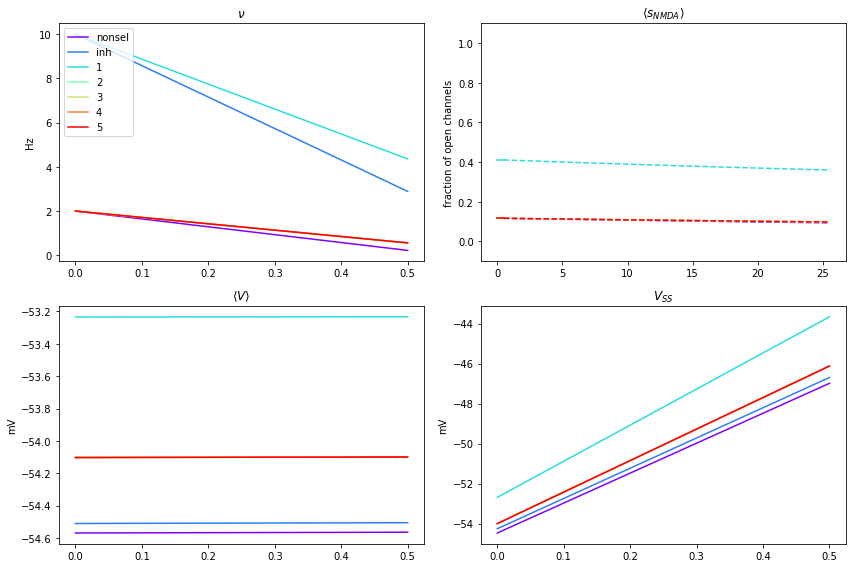

AssertionError: 1.126943325903182 not within bounds [0, 1]

In [78]:
net = initialise_network(
    rate_pyramidal=2*b2.Hz,
    rate_interneuron=10*b2.Hz,
    rate_pyramidal_1=10*b2.Hz
)
# net = initialise_network(rate_pyramidal_1=rate_pyramidal_1)
dynamic_neuron_groups = [n for n in net.nodes() if isinstance(n, NeuronGroup)]
colours = {n:cm.rainbow(i/(len(dynamic_neuron_groups)-1))
           for i, n in enumerate(dynamic_neuron_groups)}

param_tracker = EffectiveParameterTracker(net)
param_tracker.update()  # initialise with starting values

N_steps = 100
plot_start_step = 0
plot_every = 1
N_steps_lookahead = 50

# Doesn't allow xi=0 input
# def predict_trajectory(
#     deriv_method,
#     deriv_kwarg_initial_value,
#     steps_ahead=N_steps_lookahead
# ):
#     assert len(deriv_kwarg_initial_value) == 1, "Only input initial value"
#     for k, v in deriv_kwarg_initial_value.items():
#         initial_value = v
#     trajectory = [initial_value]
#     for j in range(steps_ahead):
#         for k in deriv_kwarg_initial_value.keys():
#             deriv_kwarg_initial_value[k] = trajectory[-1]
#         new_value = deriv_method(**deriv_kwarg_initial_value)*defaultdt + trajectory[-1]
#         trajectory.append(new_value)
#     return trajectory

update_parameters = dict(
    nu_update='selfconsistent',
    V_avg_update='asymptote',
    s_NMDA_update='euler',  # Euler always seem to break on second step
    all_simultaneous=True
)

# for plotting V_SS:
V_SS_trajectories = {n: [n.V_SS()] for n in dynamic_neuron_groups}
for i in range(1, N_steps+1):
    # update step
    update_step(
        dynamic_neuron_groups,
        param_tracker=param_tracker,
        **update_parameters
    )
    
    # plot step: plot everything
    for n in dynamic_neuron_groups:
        V_SS_trajectories[n].append(n.V_SS())
    
    if i < plot_start_step: continue
    elif i % plot_every != 0: continue
    
    predictions_s_NMDA = {}
    predictions_DeltaI = {}
    predictions_h = {}
    predictions_nu = {}
    for n in dynamic_neuron_groups:
        # TODO: make this loop into a function
        if update_parameters['s_NMDA_update'] == 'euler':
            # s_NMDA
            if isinstance(n, PyramidalGroup):
                s_NMDA_trajectory = [n.s_NMDA()]
                for j in range(N_steps_lookahead):
                    s_NMDA = n.ds_NMDA_Dt(s_NMDA=s_NMDA_trajectory[-1]) * defaultdt + s_NMDA_trajectory[-1]
                    s_NMDA_trajectory.append(s_NMDA)
                predictions_s_NMDA[n] = s_NMDA_trajectory

        if update_parameters['nu_update'] == 'inputpotential':
            # DeltaI
            DeltaI_trajectory = [n.DeltaI()]
            for j in range(N_steps_lookahead):
                DeltaI = n.dDeltaIDt(
                    DeltaI=DeltaI_trajectory[-1],
                    xi=0 * np.sqrt(b2.Hz)
                ) * defaultdt + DeltaI_trajectory[-1]
                DeltaI_trajectory.append(DeltaI)
            predictions_DeltaI[n] = DeltaI_trajectory
            # h
            h_trajectory = [n.h()]
            for j in range(N_steps_lookahead):
                h = n.dhDt(
                    h=h_trajectory[-1],
                ) * defaultdt + h_trajectory[-1]
                h_trajectory.append(h)
            predictions_h[n] = h_trajectory

        if update_parameters['nu_update'] == 'euler':
            # nu
            nu_trajectory = [n.nu()]
            for j in range(N_steps_lookahead):
                nu = n.dnuDt(nu=nu_trajectory[-1]) * defaultdt + nu_trajectory[-1]
                nu_trajectory.append(nu)
            predictions_nu[n] = nu_trajectory
        
    clear_output(wait=True)
    fig, axes = plt.subplots(3, 2, figsize=(12, 12)) \
        if update_parameters['nu_update'] == 'inputpotential' \
        else plt.subplots(2, 2, figsize=(12, 8))
    steps_so_far = np.arange(0, i+1) * defaultdt / b2.ms
    steps_lookahead = np.arange(i, i+1+N_steps_lookahead) * defaultdt / b2.ms
    for n in dynamic_neuron_groups:
        # nu
        axes[0,0].plot(
            steps_so_far, n.nu_trace / b2.Hz,
            color=colours[n], label=str(n))
        if update_parameters['nu_update'] == 'euler':
            axes[0,0].plot(
                steps_lookahead, predictions_nu[n]  / b2.Hz,
                '--', color=colours[n])
        # s_NMDA
        if isinstance(n, PyramidalGroup):
            axes[0,1].plot(
                steps_so_far, n.s_NMDA_trace,
                color=colours[n])
            if update_parameters['s_NMDA_update'] == 'euler':
                axes[0,1].plot(
                    steps_lookahead, predictions_s_NMDA[n],
                    '--', color=colours[n])
        # V_avg
        axes[1,0].plot(
            steps_so_far, n.V_avg_trace / b2.mV,
            color=colours[n])
        # V_SS
        axes[1,1].plot(
            steps_so_far, V_SS_trajectories[n] / b2.mV,
            color=colours[n])
        if update_parameters['nu_update'] == 'inputpotential':
            # h
            axes[2,0].plot(
                steps_so_far, n.h_trace / b2.mV,
                color=colours[n])
            axes[2,0].plot(
                steps_lookahead, predictions_h[n] / b2.mV,
                '--', color=colours[n])
            # DeltaI
            axes[2,1].plot(
                steps_so_far, n.DeltaI_trace / b2.pamp,
                color=colours[n])
            axes[2,1].plot(
                steps_lookahead, predictions_DeltaI[n] / b2.pamp,
                '--', color=colours[n])
    axes[0,0].legend(loc='upper left')
    lb, ub = axes[0,0].get_ylim()
    axes[0,0].set_ylim([lb, min(ub, 300)])
    axes[0,0].set_title(r'$\nu$')
    axes[0,0].set_ylabel('Hz')
    axes[0,1].set_title(r'$\langle s_{NMDA} \rangle$')
    axes[0,1].set_ylabel('fraction of open channels')
    axes[0,1].set_ylim([-0.1, 1.1])
    axes[1,0].set_title(r'$\langle V \rangle$')
    axes[1,0].set_ylabel('mV')
    axes[1,1].set_title('$V_{SS}$')
    axes[1,1].set_ylabel('mV')
    if update_parameters['nu_update'] == 'inputpotential':
        axes[2,0].set_title('$h$')
        axes[2,0].set_ylabel('mV')
        axes[2,1].set_title(r'$\Delta I$')
        axes[2,1].set_ylabel('pA')
    fig.tight_layout()
    plt.show()
#     sleep(0.1)

Should $h$ be increasing while firing rates and $\langle S_{NMDA} \rangle$ go down? Possibly $V_{SS}$ goes up as the firing rate goes down, which changes $\mu_C^{eff}$ ... ?

## Check the calculations manually...

In [81]:
net = initialise_network(rate_pyramidal_1=rate_pyramidal)

# Some worked calculations, starting with a selective pyramidal neuron
n = [n for n in net.nodes if isinstance(n, PyramidalGroup)][1]

print('\t===INITIAL VALUES===')
print('Initial <V>: ', n.V_avg())
# V_avg_initial = -52.35786089494559 * b2.mV
V_avg_initial = n.V_avg()  # obtained from self-consistent setting anyway
C_I = N_I
C_k = N_sub
C_0 = N_non

# EFFECTIVE PARAMETERS
J_V = J(V_avg_initial)  # assuming J, J_2 are error-free
J2_V = J_2(V_avg_initial)
g_NMDA_eff = g_NMDA_E * J2_V
print('g_NMDA_eff: ', g_NMDA_eff, ' == ', n.g_NMDA_eff())

# g_m_eff
g_m_eff = sum([
    C_ext * g_AMPA_ext_E * (tau_AMPA * rate_ext),
    C_I * g_GABA_E * (tau_GABA * rate_interneuron),
    (C_0 + w_plus*C_k + w_minus*C_k*(p-1)) * (rate_pyramidal * tau_AMPA) * g_AMPA_rec_E,
    (C_0 + w_plus*C_k + w_minus*C_k*(p-1)) * psi(rate_pyramidal) * g_NMDA_eff,
    g_m_E
])
print('g_m_eff: ', g_m_eff, ' == ', n.g_m_eff())

# V_SS
V_E_eff = V_avg_initial - (g_NMDA_E / g_NMDA_eff) * (V_avg_initial - V_E)/J_V
print('V_E_eff: ', V_E_eff, ' == ', n.V_E_eff())

V_SS = sum([
    C_ext * g_AMPA_ext_E * (tau_AMPA * rate_ext) * V_E,
    C_I * g_GABA_E * (tau_GABA * rate_interneuron) * V_I,
    (C_0 + w_plus*C_k + w_minus*C_k*(p-1)) * (rate_pyramidal * tau_AMPA) * g_AMPA_rec_E * V_E,
    (C_0 + w_plus*C_k + w_minus*C_k*(p-1)) * psi(rate_pyramidal) * g_NMDA_eff * V_E_eff,
    g_m_E * V_L
])/ g_m_eff
print('V_SS: ', V_SS, ' == ', n.V_SS())

tau_m_eff = C_m_E / g_m_eff
print('tau_m_eff: ', tau_m_eff, ' == ', n.tau_m_eff())

print('<s_AMPA>(t=0): ', rate_pyramidal * tau_AMPA, ' == ', n.s_AMPA())
print('<s_NMDA>(t=0): ', psi(rate_pyramidal), ' == ', n.s_NMDA())
tau_NMDA_eff = tau_NMDA * (1-psi(rate_pyramidal))
print('tau_NMDA_eff: ', tau_NMDA_eff, ' == ', n.tau_NMDA_eff())
mu_C_eff = V_SS * g_m_eff - V_L * g_m_E
print('mu_C_eff: ', mu_C_eff, ' == ', n.mu_C_eff())
sigma_C_eff = np.sqrt(g_AMPA_ext_E**2 * (V_avg_initial - V_E)**2 * C_ext * (tau_AMPA * rate_ext) * tau_AMPA)
print('sigma_C_eff: ', sigma_C_eff, ' == ', n.sigma_C_eff())
sigma_V_eff = sigma_C_eff * np.sqrt(tau_m_eff) / C_m_E
print('sigma_V_eff: ', sigma_V_eff, ' == ', n.sigma_V_eff())

# UPDATE STEPS
s_NMDA_0 = psi(rate_pyramidal)
ds_NMDA_Dt_0 = -(1/tau_NMDA_eff) * (s_NMDA_0 - psi(rate_pyramidal))  # should be zero
print('ds_NMDA/dt(t=0): ', ds_NMDA_Dt_0, ' == ', n.ds_NMDA_Dt())
print('<s_NMDA>(t=1): ', ds_NMDA_Dt_0 * defaultdt + s_NMDA_0, ' == ', n.compute_new_s_NMDA())
print('\n\t===(NO NEED TO UPDATE <s_NMDA> TO A NEW VALUE UNTIL AFTER OTHER UPDATES)===')

b = np.sqrt(tau_AMPA / tau_m_eff)
a = 1.03
V_thr_eff = V_thr + sigma_V_eff * a * b
V_reset_eff = V_reset + sigma_V_eff * a * b
print('V_thr_eff: ', V_thr_eff, ' == ', n.V_thr_eff())
print('V_reset_eff: ', V_reset_eff, ' == ', n.V_reset_eff())
upper, lower = (V_thr_eff - V_SS)/sigma_V_eff, (V_reset_eff - V_SS)/sigma_V_eff
print('integral bounds: ', (lower, upper), ' == ', n.first_passage_bounds_Vsteadystate())
nu_SS = phi_siegert(tau_rp_E, tau_m_eff, lower, upper)
print('nu(t=1), using V_SS: ', nu_SS, ' == ', n.compute_new_firing_rate_Vsteadystate())
dnuDt = -(rate_pyramidal - nu_SS) / tau_m_eff
print('dnu/dt(t=0), using dynamic nu formulation: ', dnuDt, ' == ', n.dnuDt())
nu_euler = dnuDt * defaultdt + rate_pyramidal
print('nu(t=1), using Euler update: ', nu_euler, ' == ', n.compute_new_firing_rate_euler())

print('\n\t===UPDATE nu TO nu(t=1) USING V_SS VALUE===')
# do V_SS update
n.nu_trace.append(nu_SS)

g_m_eff_after_rate_update = sum([
    C_ext * g_AMPA_ext_E * (tau_AMPA * rate_ext),
    C_I * g_GABA_E * (tau_GABA * rate_interneuron),
    (C_0 + w_minus*C_k*(p-1)) * (rate_pyramidal * tau_AMPA) * g_AMPA_rec_E,
    w_plus*C_k * nu_SS * tau_AMPA * g_AMPA_rec_E,
    
    (C_0 + w_minus*C_k*(p-1)) * psi(rate_pyramidal) * g_NMDA_eff,
    w_plus*C_k * s_NMDA_0 * g_NMDA_eff,
    g_m_E
])
print('g_m_eff: ', g_m_eff_after_rate_update, ' == ', n.g_m_eff())

V_SS_after_rate_update = sum([
    C_ext * g_AMPA_ext_E * (tau_AMPA * rate_ext) * V_E,
    C_I * g_GABA_E * (tau_GABA * rate_interneuron) * V_I,
    (C_0 + w_minus*C_k*(p-1)) * (rate_pyramidal * tau_AMPA) * g_AMPA_rec_E * V_E,
    w_plus*C_k * nu_SS * tau_AMPA * g_AMPA_rec_E * V_E,
    (C_0 + w_minus*C_k*(p-1)) * psi(rate_pyramidal) * g_NMDA_eff * V_E_eff,
    w_plus*C_k * s_NMDA_0 * g_NMDA_eff * V_E_eff,
    g_m_E * V_L
])/ g_m_eff_after_rate_update
print('V_SS: ', V_SS_after_rate_update, ' == ', n.V_SS())

tau_m_eff_after_rate_update = C_m_E / g_m_eff_after_rate_update
print('tau_m_eff: ', tau_m_eff_after_rate_update, ' == ', n.tau_m_eff())

V_avg_after_rate_update = V_SS_after_rate_update - (V_thr - V_reset)*nu_SS*tau_m_eff_after_rate_update - (V_SS_after_rate_update - V_reset)*nu_SS*tau_rp_E # approximate
dV_avgDt_given, asymptote_given = n.dV_avgDt(V_avg=V_avg_initial, return_asymptote=True)
print('<V>: ', V_avg_after_rate_update, ' == ', asymptote_given)
print('<V> (compared to self-consistent): ', V_avg_after_rate_update, ' ~= ', n.compute_new_V_avg_selfconsistently())

print('\n\t===UPDATE <V> TO NEW VALUE===')
n.V_avg_trace.append(V_avg_after_rate_update)
J_V = J(V_avg_after_rate_update)
J2_V = J_2(V_avg_after_rate_update)
g_NMDA_eff_after_V_update = g_NMDA_E * J2_V
print('g_NMDA_eff: ', g_NMDA_eff_after_V_update, ' == ', n.g_NMDA_eff())

g_m_eff_after_V_update = sum([
    C_ext * g_AMPA_ext_E * (tau_AMPA * rate_ext),
    C_I * g_GABA_E * (tau_GABA * rate_interneuron),
    (C_0 + w_minus*C_k*(p-1)) * (rate_pyramidal * tau_AMPA) * g_AMPA_rec_E,
    w_plus*C_k * nu_SS * tau_AMPA * g_AMPA_rec_E,
    
    (C_0 + w_minus*C_k*(p-1)) * psi(rate_pyramidal) * g_NMDA_eff_after_V_update,
    w_plus*C_k * s_NMDA_0 * g_NMDA_eff_after_V_update,
    g_m_E
])
print('g_m_eff: ', g_m_eff_after_V_update, ' == ', n.g_m_eff())

V_E_eff_after_V_update = V_avg_after_rate_update - (g_NMDA_E / g_NMDA_eff_after_V_update) * (V_avg_after_rate_update - V_E)/J_V
print('V_E_eff: ', V_E_eff_after_V_update, ' == ', n.V_E_eff())

V_SS_after_V_update = sum([
    C_ext * g_AMPA_ext_E * (tau_AMPA * rate_ext) * V_E,
    C_I * g_GABA_E * (tau_GABA * rate_interneuron) * V_I,
    (C_0 + w_minus*C_k*(p-1)) * (rate_pyramidal * tau_AMPA) * g_AMPA_rec_E * V_E,
    w_plus*C_k * nu_SS * tau_AMPA * g_AMPA_rec_E * V_E,
    (C_0 + w_minus*C_k*(p-1)) * psi(rate_pyramidal) * g_NMDA_eff_after_V_update * V_E_eff_after_V_update,
    w_plus*C_k * s_NMDA_0 * g_NMDA_eff_after_V_update * V_E_eff_after_V_update,
    g_m_E * V_L
])/ g_m_eff_after_V_update
print('V_SS: ', V_SS_after_V_update, ' == ', n.V_SS())

tau_m_eff_after_V_update = C_m_E / g_m_eff_after_V_update
print('tau_m_eff: ', tau_m_eff_after_V_update, ' == ', n.tau_m_eff())

print('<s_AMPA>(t=0): ', nu_SS * tau_AMPA, ' == ', n.s_AMPA())
tau_NMDA_eff_after_V_update = tau_NMDA * (1-psi(nu_SS))
print('tau_NMDA_eff: ', tau_NMDA_eff_after_V_update, ' == ', n.tau_NMDA_eff())
mu_C_eff_after_V_update = V_SS_after_V_update * g_m_eff_after_V_update - V_L * g_m_E
print('mu_C_eff: ', mu_C_eff_after_V_update, ' == ', n.mu_C_eff())
sigma_C_eff_after_V_update = np.sqrt(g_AMPA_ext_E**2 * (V_avg_after_rate_update - V_E)**2 * C_ext * (tau_AMPA * rate_ext) * tau_AMPA)
print('sigma_C_eff: ', sigma_C_eff_after_V_update, ' == ', n.sigma_C_eff())
sigma_V_eff_after_V_update = sigma_C_eff_after_V_update * np.sqrt(tau_m_eff_after_V_update) / C_m_E
print('sigma_V_eff: ', sigma_V_eff_after_V_update, ' == ', n.sigma_V_eff())

s_NMDA_1 = s_NMDA_0
ds_NMDA_Dt_1 = -(1/tau_NMDA_eff_after_V_update) * (s_NMDA_0 - psi(nu_SS))  # should be zero
s_NMDA_newest = ds_NMDA_Dt_1 * defaultdt + s_NMDA_1
print('ds_NMDA/dt(t=1): ', ds_NMDA_Dt_1, ' == ', n.ds_NMDA_Dt())
print('<s_NMDA>(t=2): ', s_NMDA_newest, ' == ', n.compute_new_s_NMDA())

print('\n\t===UPDATE <s_NMDA> TO NEW VALUE===')
n.s_NMDA_trace.append(s_NMDA_newest)
g_m_eff_after_s_NMDA_update = sum([
    C_ext * g_AMPA_ext_E * (tau_AMPA * rate_ext),
    C_I * g_GABA_E * (tau_GABA * rate_interneuron),
    (C_0 + w_minus*C_k*(p-1)) * (rate_pyramidal * tau_AMPA) * g_AMPA_rec_E,
    w_plus*C_k * nu_SS * tau_AMPA * g_AMPA_rec_E,
    
    (C_0 + w_minus*C_k*(p-1)) * psi(rate_pyramidal) * g_NMDA_eff_after_V_update,
    w_plus*C_k * s_NMDA_newest * g_NMDA_eff_after_V_update,
    g_m_E
])
print('g_m_eff: ', g_m_eff_after_s_NMDA_update, ' == ', n.g_m_eff())

V_SS_after_s_NMDA_update = sum([
    C_ext * g_AMPA_ext_E * (tau_AMPA * rate_ext) * V_E,
    C_I * g_GABA_E * (tau_GABA * rate_interneuron) * V_I,
    (C_0 + w_minus*C_k*(p-1)) * (rate_pyramidal * tau_AMPA) * g_AMPA_rec_E * V_E,
    w_plus*C_k * nu_SS * tau_AMPA * g_AMPA_rec_E * V_E,
    (C_0 + w_minus*C_k*(p-1)) * psi(rate_pyramidal) * g_NMDA_eff_after_V_update * V_E_eff_after_V_update,
    w_plus*C_k * s_NMDA_newest * g_NMDA_eff_after_V_update * V_E_eff_after_V_update,
    g_m_E * V_L
])/ g_m_eff_after_s_NMDA_update
print('V_SS: ', V_SS_after_s_NMDA_update, ' == ', n.V_SS())

tau_m_eff_after_s_NMDA_update = C_m_E / g_m_eff_after_s_NMDA_update
print('tau_m_eff: ', tau_m_eff_after_s_NMDA_update, ' == ', n.tau_m_eff())

	===INITIAL VALUES===
Initial <V>:  -58.78678231 mV
g_NMDA_eff:  -65.10984186 pS  ==  -65.10984186 pS
g_m_eff:  76.29222297 nS  ==  76.29222297 nS
V_E_eff:  -83.97584317 mV  ==  -83.97584317 mV
V_SS:  -58.66414632 mV  ==  -58.66414632 mV
tau_m_eff:  6.55374795 ms  ==  6.55374795 ms
<s_AMPA>(t=0):  0.006  ==  0.006
<s_NMDA>(t=0):  0.16684120309074604  ==  0.16684120309074604
tau_NMDA_eff:  83.31587969 ms  ==  83.31587969 ms
mu_C_eff:  -2.72561813 nA  ==  -2.72561813 nA
sigma_C_eff:  1.1980602e-11 s^0.5 A  ==  1.1980602e-11 s^0.5 A
sigma_V_eff:  1.93978459 mV  ==  1.93978459 mV
ds_NMDA/dt(t=0):  -0. Hz  ==  -0. Hz
<s_NMDA>(t=1):  0.16684120309074604  ==  0.16684120309074604

	===(NO NEED TO UPDATE <s_NMDA> TO A NEW VALUE UNTIL AFTER OTHER UPDATES)===
V_thr_eff:  -48.89627505 mV  ==  -48.89627505 mV
V_reset_eff:  -53.89627505 mV  ==  -53.89627505 mV
integral bounds:  (2.457938524907907, 5.035544322763522)  ==  (2.4579385249078896, 5.0355443227635055)
nu(t=1), using V_SS:  4.12733654 nHz  

In [ ]:
param_tracker = EffectiveParameterTracker(net)
param_tracker.update()

dynamic_neuron_groups = [n for n in net.nodes() if isinstance(n, NeuronGroup)]

N_steps = 130  # breaks just after 55 for defaultdt = 0.1 ms

for i in range(N_steps):
    # step 1: compute new average membrane potentials self-consistently
    new_V_avg = {}
    for n in dynamic_neuron_groups:
        new_V_avg[n] = n.compute_new_V_avg_selfconsistently()
    for n in dynamic_neuron_groups:
        n.V_avg_trace.append(new_V_avg[n])

    # step 2: update dynamic values
    # step 2.1: update s_NMDA
    new_s_NMDA = {}
    for n in dynamic_neuron_groups:
        if isinstance(n, PyramidalGroup):
            new_s_NMDA[n] = n.compute_new_s_NMDA()
    for n in dynamic_neuron_groups:
        if isinstance(n, PyramidalGroup):
            n.s_NMDA_trace.append(new_s_NMDA[n])
    # step 2.2: update DeltaI
    new_DeltaI = {}
    for n in dynamic_neuron_groups:
        new_DeltaI[n] = n.compute_new_DeltaI()
    for n in dynamic_neuron_groups:
        n.DeltaI_trace.append(new_DeltaI[n])
    # step 2.3: update h
    new_h = {}
    for n in dynamic_neuron_groups:
        new_h[n] = n.compute_new_h()
    for n in dynamic_neuron_groups:
        n.h_trace.append(new_h[n])

    # step 3: compute new firing rates
    new_nu = {}
    for n in dynamic_neuron_groups:
#         new_nu[n] = n.compute_new_firing_rate()
        new_nu[n] = n.compute_new_firing_rate_Vsteadystate()
    for n in dynamic_neuron_groups:
        n.nu_trace.append(new_nu[n])
        
    # debug step: update effective parameter tracker
    param_tracker.update()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

n = dynamic_neuron_groups[0]
ax.plot(np.array(n.V_avg_trace) / b2.mV, 'r')
ax.set_ylabel('average membrane potential (mV)\nsolid line')

ax2 = ax.twinx()
ax2.plot(np.array(n.nu_trace) / b2.Hz, 'k--')
ax2.set_ylabel('firing rate (Hz)\ndashed line')

plt.title('When does it go wrong?')
plt.show()

In [ ]:
def plot_sim(net):
    dynamic_neuron_groups = [n for n in net.nodes() if isinstance(n, NeuronGroup)]
    fig, axes = plt.subplots(3, 2, figsize=(12, 8))
    for n in dynamic_neuron_groups:
        axes[0,0].plot(np.array(n.V_avg_trace) / b2.mV)
        if isinstance(n, PyramidalGroup):
            axes[0,1].plot(np.array(n.s_NMDA_trace))
        axes[1,0].plot(np.array(n.DeltaI_trace) / b2.amp)
        axes[1,1].plot(np.array(n.h_trace) / b2.mV)
        axes[2,0].plot(np.array(n.nu_trace) / b2.Hz)

    axes[0,0].set_title(r'$\langle V \rangle$')
    axes[0,0].set_xticks([])
    # axes[0,0].set_ylim([-90, -20])

    axes[0,1].set_title(r'$\langle s_{NMDA} \rangle$')
    axes[0,1].set_xticks([])
    axes[1,0].set_title(r'$\Delta I$')
    axes[1,0].set_xticks([])
    axes[1,1].set_title(r'$h$')
    axes[2,0].set_title(r'$\nu$')
    axes[2,1].axis('off')
    fig.tight_layout()
    plt.show()

plot_sim(net)

### Plan A didn't work, so we try a simpler model:

```
for k in pyramidal_neuron_group_indices:
  update s_NMDA_k

# run until convergence:
nu_vec = np.array([n.nu() for n in neuron_groups])
tau_vec = np.array([n.tau_m_eff() for n in neuron_groups])
dnuDt_vec = np.array([-nu_vec[i] + n.phi_siegert() for i,n in enumerate(neuron_groups)])
nu_vec_new = nu_vec + defaultdt * (dnuDt_vec @ tau_vec**-1)

# once converged:
for i, n in enumerate(neuron_groups):
  n.nu_trace.append(nu_vec_new[i])
```
Unfortunately, this raises recursion errors, as `n.g_NMDA_eff()` calls `n.V_avg()` which calls `n.V_SS()` which calls `n.g_NMDA_eff()`. Some refactoring will be necessary.  
Alternatively, setting `n.V_avg()` to return a constant should fix the problem.

In [ ]:
b2.get_dimensions(defaultdt*(n.nu() + n.compute_new_firing_rate_Vsteadystate()) * n.tau_m_eff()**-1)

In [ ]:
# assert b2.get_dimensions([5 * b2.Hz] * 4 == b2.Hz)
# # works
# assert b2.get_dimensions(np.array([5 * b2.Hz] * 4) == b2.Hz)
# # fails

In [ ]:
b2.get_dimensions(np.array([n.compute_new_firing_rate_Vsteadystate() for n in dynamic_neuron_groups]))
# np.array destroys dimensions...

In [ ]:
def update_rates_selfconsistently(net, tolerance=0.1*b2.Hz, max_steps=200):
    # add initial rates to new value in trace, for access by effective functions
    dynamic_neuron_groups = [n for n in net.nodes() if isinstance(n, NeuronGroup)]
    for n in dynamic_neuron_groups:
        n.nu_trace.append(n.nu_trace[-1])
    for iter_ in range(max_steps):
        # compute dynamically incremented rates
        nu_vec = np.array([n.nu() for n in dynamic_neuron_groups])
        tau_vec = np.array([n.tau_m_eff() for n in dynamic_neuron_groups])
        asymptote = np.array([n.compute_new_firing_rate_Vsteadystate() for n in dynamic_neuron_groups])
        dnuDt_vec = (-nu_vec + asymptote) * (tau_vec**-1)
        # workaround to avoid unit loss error
        nu_vec_new = nu_vec + (defaultdt/b2.second) * dnuDt_vec
        # update rates with new values
        for i, n in enumerate(dynamic_neuron_groups):
            n.nu_trace[-1] = nu_vec_new[i] * b2.Hz
        # check for convergence
        diff = np.sqrt( np.sum((asymptote - nu_vec_new)**2))
        if diff*b2.Hz < tolerance:
            break
    else:
        print(f"Firing rates did not converge: diff = {diff} Hz")


In [ ]:
net = initialise_network()
param_tracker = EffectiveParameterTracker(net)
param_tracker.update()

N_steps = 130
dynamic_neuron_groups = [n for n in net.nodes() if isinstance(n, NeuronGroup)]

N_steps = 130  # breaks just after 55 for defaultdt = 0.1 ms

for i in range(N_steps):
    # step 1: update s_NMDA values
    new_s_NMDA = {}
    for n in dynamic_neuron_groups:
        if isinstance(n, PyramidalGroup):
            new_s_NMDA[n] = n.compute_new_s_NMDA()
    for n in dynamic_neuron_groups:
        if isinstance(n, PyramidalGroup):
            n.s_NMDA_trace.append(new_s_NMDA[n])
    # update rates self-consistently
    update_rates_selfconsistently(net)
    param_tracker.update()

### Debugging below...

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(18, 12))

# start = N_steps - 20
start = 0
end = len(n.nu_trace)
xaxis = np.arange(start, end) #* defaultdt / b2.ms

for n in param_tracker.tau_NMDA_eff.keys():
    axes[0,0].plot(xaxis, param_tracker.tau_NMDA_eff[n][start:end] / b2.ms)
ax2 = axes[0,0].twinx()
for n in dynamic_neuron_groups:
    ax2.plot(xaxis, np.array(n.nu_trace)[start:end] / b2.Hz, 'k:', alpha=0.5)
axes[0,0].set_title(r"$\tau_{NMDA}^{eff}$ (ms)")

for n in param_tracker.V_reset_eff.keys():
    axes[0,1].plot(xaxis, param_tracker.V_reset_eff[n][start:end] / b2.mV)
ax2 = axes[0,1].twinx()
for n in dynamic_neuron_groups:
    ax2.plot(xaxis, np.array(n.nu_trace)[start:end] / b2.Hz, 'k:', alpha=0.5)
axes[0,1].set_title(r"$V_{reset}^{eff}$ (mV)")

for n in param_tracker.V_thr_eff.keys():
    axes[0,2].plot(xaxis, param_tracker.V_thr_eff[n][start:end] / b2.mV)
ax2 = axes[0,2].twinx()
for n in dynamic_neuron_groups:
    ax2.plot(xaxis, np.array(n.nu_trace)[start:end] / b2.Hz, 'k:', alpha=0.5)
axes[0,2].set_title(r"$V_{thr}^{eff}$ (mV)")

for n in param_tracker.mu_C_eff.keys():
    axes[1,0].plot(xaxis, param_tracker.mu_C_eff[n][start:end] / b2.nA)
ax2 = axes[1,0].twinx()
for n in dynamic_neuron_groups:
    ax2.plot(xaxis, np.array(n.nu_trace)[start:end] / b2.Hz, 'k:', alpha=0.5)
axes[1,0].set_title(r"$\mu_{C}^{eff}$ (nA)")

for n in param_tracker.sigma_V_eff.keys():
    axes[1,1].plot(xaxis, param_tracker.sigma_V_eff[n][start:end] / b2.mV)
ax2 = axes[1,1].twinx()
for n in dynamic_neuron_groups:
    ax2.plot(xaxis, np.array(n.nu_trace)[start:end] / b2.Hz, 'k:', alpha=0.5)
axes[1,1].set_title(r"$\sigma_{V}^{eff}$ (mV)")

for n in param_tracker.sigma_C_eff.keys():
    axes[1,2].plot(xaxis, param_tracker.sigma_C_eff[n][start:end] / (b2.nA * np.sqrt(b2.second)))
ax2 = axes[1,2].twinx()
for n in dynamic_neuron_groups:
    ax2.plot(xaxis, np.array(n.nu_trace)[start:end] / b2.Hz, 'k:', alpha=0.5)
axes[1,2].set_title(r"$\sigma_{C}^{eff}$ (nA s^0.5)")

for n in param_tracker.V_SS.keys():
    axes[2,0].plot(xaxis, param_tracker.V_SS[n][start:end] / b2.mV)
ax2 = axes[2,0].twinx()
for n in dynamic_neuron_groups:
    ax2.plot(xaxis, np.array(n.nu_trace)[start:end] / b2.Hz, 'k:', alpha=0.5)
axes[2,0].set_title(r"$V_{SS}$ (mV)")

for n in param_tracker.V_E_eff.keys():
    axes[2,1].plot(xaxis, param_tracker.V_E_eff[n][start:end] / b2.mV)
ax2 = axes[2,1].twinx()
for n in dynamic_neuron_groups:
    ax2.plot(xaxis, np.array(n.nu_trace)[start:end] / b2.Hz, 'k:', alpha=0.5)
axes[2,1].set_title(r"$V_{E}^{eff}$ (mV)")

for n in param_tracker.tau_m_eff.keys():
    axes[2,2].plot(xaxis, param_tracker.tau_m_eff[n][start:end] / b2.ms)
ax2 = axes[2,2].twinx()
for n in dynamic_neuron_groups:
    ax2.plot(xaxis, np.array(n.nu_trace)[start:end] / b2.Hz, 'k:', alpha=0.5)
axes[2,2].set_title(r"$\tau_{m}^{eff}$ (ms)")

for n in param_tracker.g_m_eff.keys():
    axes[3,0].plot(xaxis, param_tracker.g_m_eff[n][start:end] / b2.nS)
ax2 = axes[3,0].twinx()
for n in dynamic_neuron_groups:
    ax2.plot(xaxis, np.array(n.nu_trace)[start:end] / b2.Hz, 'k:', alpha=0.5)
axes[3,0].set_title(r"$g_{m}^{eff}$ (nS)")

for n in param_tracker.g_NMDA_eff.keys():
    axes[3,1].plot(xaxis, param_tracker.g_NMDA_eff[n][start:end] / b2.nS)
ax2 = axes[3,1].twinx()
for n in dynamic_neuron_groups:
    ax2.plot(xaxis, np.array(n.nu_trace)[start:end] / b2.Hz, 'k:', alpha=0.5)
axes[3,1].set_title(r"$g_{NMDA}^{eff}$ (nS)")

for n in param_tracker.integral_bounds.keys():
    lower = [x[0] for x in param_tracker.integral_bounds[n][start:end]]
    upper = [x[1] for x in param_tracker.integral_bounds[n][start:end]]
    axes[3,2].plot(xaxis, lower, label="lower")
    axes[3,2].plot(xaxis, lower, label="upper")
    break
axes[3,2].legend()

# for n in dynamic_neuron_groups:
#     upper, lower = 
#     ax2.plot(xaxis, np.array(n.nu_trace)[start:end] / b2.Hz, 'k:', alpha=0.5)
# axes[3,2].set_title(r"Integral bounds")

# axes[3,2].axis("off")

fig.tight_layout()

plt.show()

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(np.array(upper)) 
plt.plot(np.array(lower))
plt.grid()

In [ ]:
np.min(np.abs(np.array(upper) - np.array(lower))[:-9])

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(np.array(upper) - np.array(lower))
plt.grid()

In [ ]:
np.sign(n.g_AMPA * (V_reset - V_E)) == np.sign(n.g_NMDA_eff() * (V_reset - n.V_E_eff()))

In [ ]:
# cf. pg 449, these values are finall correct!
n.V_avg_trace[0] = -55*b2.mV
print(f"{n.g_NMDA_eff() / n.g_NMDA} ~ 0.22", f"{n.V_E_eff() / b2.mV} ~ -81.8", sep='\n')

In [ ]:
n.sigma_C_eff() / np.sqrt(b2.second)

In [ ]:
print("<s_NMDA>:", n.s_NMDA(), "--->", n.compute_new_s_NMDA())
print("DeltaI:  ", n.DeltaI(), "--->", n.compute_new_DeltaI())
print("h:       ", n.h(), "--->", n.compute_new_h())

In [ ]:
n.C_m = 0.25 * b2.nF
n.C_m

In [ ]:
n.g_NMDA_eff(), n.g_NMDA

In [ ]:
n.g_NMDA_eff() * (V_ - n.V_E_eff())

In [ ]:
n.g_m, n.g_m_eff()

In [ ]:
n.tau_m(), n.tau_m_eff()

In [ ]:
n.nu(),\
n.g_m_eff() / n.g_m,\
n.tau_m() / n.tau_m_eff()

In [ ]:
for n in dynamic_neuron_groups:
    print(n.nu(), n.compute_new_firing_rate())
    print(n.V_avg(), n.compute_new_V_avg_selfconsistently())